<a href="https://colab.research.google.com/github/ashishar/q_character/blob/main/Brahmi_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#!pip install pennylane torch torchvision torchaudio transformers pillow tqdm numpy qiskit qiskit-aer qiskit-machine-learning scikit-learn matplotlib opencv-python
# ---- 1. Downgrade JAX to a PennyLane-compatible version ----
#!pip install -q "jax>=0.6.0,<0.6.3" "jaxlib>=0.6.0,<0.6.3" --force-reinstall
#
#!pip install pennylane-lightning[gpu] cuquantum
#!pip install -q pennylane pennylane-lightning[gpu] cuquantum-python --extra-index-url=https://pypi.nvidia.com --no-cache-dir

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the desired location where the file is stored.
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [3]:
# prompt: I want to download devanagari character dataset from Kaggle.

#!pip install kaggle
#!mkdir -p ~/.kaggle
#!cp /content/drive/MyDrive/brahmi/kaggle.json ~/.kaggle/kaggle.json
#!kaggle datasets download --force -d gautamneha/brahmi-dataset
!unzip "/content/drive/My Drive/brahmi-dataset.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/test/117/26.jpg  
  inflating: /content/data/test/117/27.jpg  
  inflating: /content/data/test/117/28.jpg  
  inflating: /content/data/test/117/29.jpg  
  inflating: /content/data/test/117/30.jpg  
  inflating: /content/data/test/118/26.jpg  
  inflating: /content/data/test/118/27.jpg  
  inflating: /content/data/test/118/28.jpg  
  inflating: /content/data/test/118/29.jpg  
  inflating: /content/data/test/118/30.jpg  
  inflating: /content/data/test/119/26.jpg  
  inflating: /content/data/test/119/27.jpg  
  inflating: /content/data/test/119/28.jpg  
  inflating: /content/data/test/119/29.jpg  
  inflating: /content/data/test/119/30.jpg  
  inflating: /content/data/test/12/1.jpg  
  inflating: /content/data/test/12/11.jpg  
  inflating: /content/data/test/12/15.jpg  
  inflating: /content/data/test/12/18.jpg  
  inflating: /content/data/test/12/22.jpg  
  inflating: /content/data/test/120/26.jpg  
  inflatin

In [7]:
import math, random, os, numpy as np, torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import pennylane as qml

#from transformers import T5TokenizerFast, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

from torchvision import transforms
from skimage.morphology import skeletonize
from sklearn.preprocessing import binarize

from skimage import exposure
from skimage import io, transform
from skimage.transform import resize


def seam_carving(image, output_shape):
    """Apply seam carving to resize the image to the specified output shape."""
    image_np = image.numpy().squeeze()  # Convert to numpy and remove the channel dimension
    carved_image = resize(image_np, output_shape, anti_aliasing=True, mode='reflect')
    return torch.tensor(carved_image).unsqueeze(0)  # Convert back to tensor and add channel dimension


def binarize_image(image, threshold):
    return (image > threshold).float()

# Custom function to skeletonize the image
def skeletonize_image(image):
    image_np = image.numpy()  # Convert to NumPy array and remove channel dimension
    skeleton = skeletonize(image_np)  # Skeletonize the image
    return torch.tensor(skeleton).unsqueeze(0)  # Convert back to tensor and add channel dimension

# Custom function to flatten and normalize the image
def flatten_and_normalize(img):
    img = img.view(-1)  # Flatten the image
    #img = img[:127]  # Use only the first 127 pixels
    #norm = img.norm(p=1)  # Calculate the L2 norm
    #img = img / norm  # Normalize the image
    return img

# Custom function for histogram normalization
def histogram_normalize(img):
    img_np = img.squeeze().numpy()  # Convert to NumPy array and remove channel dimension
    img_eq = exposure.equalize_hist(img_np)  # Apply histogram normalization
    return torch.tensor(img_eq).unsqueeze(0)  # Convert back to tensor and add channel dimension


image_size= 32
# Define the transform to resize, inspect size, flatten, and normalize the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((image_size, image_size)),  # Resize all images to 28x28 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: seam_carving(x, (image_size, image_size))),  # Resize using seam carving
#    transforms.Lambda(lambda x: binarize_image(x, threshold=0.5)),  # Binarize the image
#    transforms.Lambda(skeletonize_image),  # Skeletonize the image
#    transforms.Lambda(lambda x: print(f"Image shape before flattening: {x.shape}") or x),  # Inspect size
#    transforms.Lambda(flatten_and_normalize)  # Flatten and normalize
])

# Load the datasets with the defined transformation
train_dataset_all = datasets.ImageFolder(root='/content/data/train', transform=transform)
test_dataset_all = datasets.ImageFolder(root='/content/data/test', transform=transform)

batch_size=10

# take first 100 and 30 samples
train_subset = Subset(train_dataset_all, range(1000))
test_subset  = Subset(test_dataset_all, range(300))

# Create DataLoaders
train_loader = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=batch_size, shuffle=False)

In [9]:
# Try to infer number of classes automatically from your loader
try:
    # Works for ImageFolder or similar datasets
    N_CLASSES = len(train_loader.dataset.classes)
except AttributeError:
    # If dataset has targets or labels attribute
    if hasattr(train_loader.dataset, "targets"):
        N_CLASSES = len(set(train_loader.dataset.targets))
    elif hasattr(train_loader.dataset, "labels"):
        N_CLASSES = len(set(train_loader.dataset.labels))
    else:
        # As a fallback, infer from one batch
        sample_batch = next(iter(train_loader))
        _, sample_labels = sample_batch
        N_CLASSES = int(torch.max(sample_labels).item() + 1)
print(f"Detected {N_CLASSES} classes automatically.")


Detected 170 classes automatically.


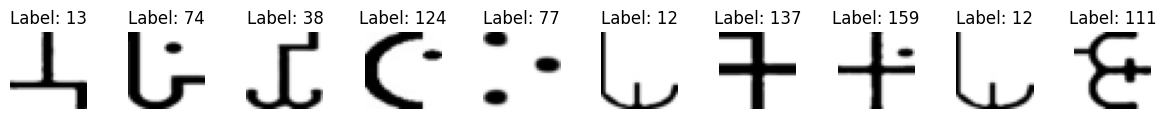

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Reshape the flattened images back to 28x28
images = images.view(-1, image_size, image_size)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 10, figsize=(15,1))
for i in range(10):
    img = images[i] / 2 + 0.5  # Unnormalize if the images were normalized
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray')  # Plot in grayscale
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()


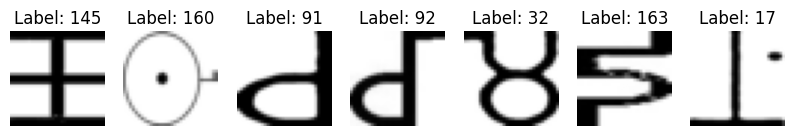

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Reshape the flattened images back to 28x28
images = images.view(-1, image_size, image_size)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 7, figsize=(10, 6))
for i in range(7):
    img = images[i] / 2 + 0.5  # Unnormalize if the images were normalized
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray')  # Plot in grayscale
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch

# ============================================================
# CONFIG
# ============================================================

OUT_ROOT = "qdrm_dataset"
CLEAN_DIR     = os.path.join(OUT_ROOT, "clean")
DEGRADED_DIR  = os.path.join(OUT_ROOT, "degraded")

os.makedirs(CLEAN_DIR, exist_ok=True)
os.makedirs(DEGRADED_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================================
# AUTO-CONVERSION FUNCTION (NO SHAPE ASSUMPTIONS)
# ============================================================

def tensor_to_image(t):
    """
    Converts ANY PyTorch image tensor to a 2D uint8 grayscale image:

    Supports:
        - (H, W)
        - (C, H, W)
        - (H, W, C)
        - values in [0,1] or [0,255]
        - 1 or 3 channels
    """

    # Move to CPU, convert to numpy
    arr = t.detach().cpu().float().numpy()

    # Remove batch dimension if present
    if arr.ndim == 4:
        arr = arr[0]

    # Handle (C,H,W) → (H,W,C)
    if arr.ndim == 3:
        if arr.shape[0] in [1,3]:  # channel-first
            arr = np.transpose(arr, (1, 2, 0))

    # If 3 channels, convert to grayscale
    if arr.ndim == 3 and arr.shape[2] == 3:
        arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)

    # If already 2D, do nothing
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr[:, :, 0]

    # Normalize to [0,255]
    if arr.max() <= 1.0:
        arr = arr * 255.0

    arr = np.clip(arr, 0, 255).astype("uint8")

    return arr


# ============================================================
# DEGRADATION FUNCTIONS
# ============================================================

def add_noise(img, sigma=18):
    n = np.random.normal(0, sigma, img.shape)
    return np.clip(img + n, 0, 255).astype(np.uint8)

def motion_blur(img, ksize=7):
    k = np.zeros((ksize, ksize))
    k[ksize//2, :] = 1.0 / ksize
    return cv2.filter2D(img, -1, k)

def erode(img):
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    return cv2.erode(img, k, iterations=1)

def low_contrast(img):
    out = img.astype(float) * np.random.uniform(0.5, 0.8) + np.random.randint(10, 30)
    return np.clip(out, 0, 255).astype(np.uint8)

def degrade(img):
    if np.random.rand() < 0.8: img = motion_blur(img)
    if np.random.rand() < 0.8: img = add_noise(img)
    if np.random.rand() < 0.6: img = erode(img)
    if np.random.rand() < 0.7: img = low_contrast(img)
    return img


# ============================================================
# PROCESS LOADER
# ============================================================

def process_loader(loader, split_name):
    rows = []
    counter = 0

    for batch in loader:
        # batch may be (images, labels) or images only
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch

        images = images.to(device)

        for timg in images:
            img = tensor_to_image(timg)     # auto-detect shape

            clean_path = os.path.join(CLEAN_DIR,     f"{split_name}_{counter:06d}.png")
            deg_path   = os.path.join(DEGRADED_DIR,  f"{split_name}_{counter:06d}_deg.png")

            # Save clean
            cv2.imwrite(clean_path, img)

            # Save degraded
            degraded = degrade(img.copy())
            cv2.imwrite(deg_path, degraded)

            rows.append({
                "degraded_path": deg_path,
                "clean_path": clean_path
            })

            counter += 1

    # Save CSV pairs
    df = pd.DataFrame(rows)
    csv_path = os.path.join(OUT_ROOT, f"{split_name}_pairs.csv")
    df.to_csv(csv_path, index=False)

    print(f"[{split_name}] {len(rows)} samples saved → {csv_path}")


# ============================================================
# RUN FOR TRAIN AND TEST LOADER
# ============================================================

process_loader(train_loader, "train")
process_loader(test_loader, "test")

print("\nDataset preparation complete!")
print("QDRM dataset saved to:", OUT_ROOT)


In [ ]:
import matplotlib.pyplot as plt
OUT_ROOT = "qdrm_dataset"

def show_samples(csv_path, title, num_samples=6):
    """
    Display degraded and clean samples side-by-side.
    Reads from train_pairs.csv or test_pairs.csv.
    """
    df = pd.read_csv(csv_path)
    df = df.sample(min(num_samples, len(df)))  # random sampling

    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    for i, row in enumerate(df.itertuples(), 1):
        deg = cv2.imread(row.degraded_path, cv2.IMREAD_GRAYSCALE)
        clean = cv2.imread(row.clean_path, cv2.IMREAD_GRAYSCALE)

        # Degraded image
        plt.subplot(2, num_samples, i)
        plt.imshow(deg, cmap="gray")
        plt.axis("off")
        plt.title("Degraded")

        # Clean image
        plt.subplot(2, num_samples, i + num_samples)
        plt.imshow(clean, cmap="gray")
        plt.axis("off")
        plt.title("Clean")

    plt.tight_layout()
    plt.show()

print("\nDisplaying sample TRAIN images...")
show_samples(os.path.join(OUT_ROOT, "train_pairs.csv"), "Train Samples")

print("\nDisplaying sample TEST images...")
show_samples(os.path.join(OUT_ROOT, "test_pairs.csv"), "Test Samples")


In [ ]:
# ============================================================
# QDRM FAST MODE (PennyLane + PyTorch) — COMPLETE SINGLE SCRIPT
# - FAST MODE: resize all images to 16×16 on load
# - NO (1,1,...) tensors: canonical shape is (C,H,W) = (1,H,W)
# - Patch-based quantum restore with 4×4 patches => 16 qubits
# - CUDA-compatible (PyTorch runs on CUDA; PennyLane default.qubit runs on CPU)
# - Progress printed every 100 images
# ============================================================

import os
import time
from typing import Tuple

import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml


# ============================================================
# 0) CONFIG
# ============================================================

CFG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    "train_csv": "qdrm_dataset/train_pairs.csv",
    "test_csv":  "qdrm_dataset/test_pairs.csv",

    # FAST MODE: always resize images to 16×16
    "image_size": (16, 16),          # (H,W)

    "patch_size": 4,                 # 4×4 patches
    "stride": 4,                     # non-overlap
    "n_qubits": 16,                  # MUST equal patch_size^2
    "n_layers": 3,

    "patch_batch": 256,              # patches per quantum minibatch
    "epochs": 3,
    "lr": 3e-4,

    "print_every": 100,

    # dataloader
    "batch_size": 1,                 # one full image at a time
    "num_workers": 0,                # set >0 on Linux if you want
    "pin_memory": True,

    "save_dir": "qdrm_fast_runs",
    "save_visuals": True,
    "save_visual_n": 6
}

os.makedirs(CFG["save_dir"], exist_ok=True)

assert CFG["patch_size"] * CFG["patch_size"] == CFG["n_qubits"], \
    "patch_size^2 must equal n_qubits (e.g., 4×4 => 16 qubits)"

print(f"[CFG] FAST MODE ENABLED → Image size: {CFG['image_size']}")
print(f"[CFG] Device (PyTorch): {CFG['device']}")
print("[NOTE] PennyLane default.qubit runs on CPU (normal).")


# ============================================================
# 1) IMAGE IO (returns canonical (1,H,W) float32 in [0,1])
# ============================================================

def load_image_01(path: str, out_hw: Tuple[int, int]) -> torch.Tensor:
    """
    Returns: torch.Tensor (1,H,W) float32 in [0,1]
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)

    # Resize for FAST MODE
    img = cv2.resize(img, (out_hw[1], out_hw[0]), interpolation=cv2.INTER_AREA)  # cv2 uses (W,H)
    img = img.astype(np.float32) / 255.0

    return torch.from_numpy(img).unsqueeze(0)  # (1,H,W)


def save_image_01(path: str, img01: np.ndarray) -> None:
    """
    img01: (H,W) in [0,1]
    """
    out = np.clip(img01 * 255.0, 0, 255).astype(np.uint8)
    cv2.imwrite(path, out)


# ============================================================
# 2) PATCHING (expects (1,H,W); adds batch dim ONLY internally)
# ============================================================

def extract_patches(img_chw: torch.Tensor) -> torch.Tensor:
    """
    img_chw: (1,H,W)
    returns: (N, ps*ps)
    """
    assert img_chw.dim() == 3 and img_chw.shape[0] == 1, f"Expected (1,H,W), got {img_chw.shape}"

    img_bchw = img_chw.unsqueeze(0)  # (1,1,H,W) only here for unfold
    patches = F.unfold(
        img_bchw,
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )  # (1, ps*ps, N)

    return patches.squeeze(0).T.contiguous()  # (N, ps*ps)


def fold_patches(patches_flat: torch.Tensor) -> torch.Tensor:
    """
    patches_flat: (N, ps*ps)
    returns: (1,H,W)
    """
    assert patches_flat.dim() == 2 and patches_flat.shape[1] == CFG["n_qubits"], \
        f"Expected (N,{CFG['n_qubits']}), got {patches_flat.shape}"

    patches_for_fold = patches_flat.T.unsqueeze(0)  # (1, ps*ps, N)

    recon = F.fold(
        patches_for_fold,
        output_size=CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )  # (1,1,H,W)

    return recon.squeeze(0)  # (1,H,W)


# ============================================================
# 3) FRQI-like angle encoding + expval->pixel mapping
# ============================================================

def pixels_to_angles(patches01: torch.Tensor) -> torch.Tensor:
    """
    patches01: (N,16) in [0,1]
    returns: angles (N,16)
    """
    return torch.arccos(torch.clamp(patches01, 0.0, 1.0))


def expval_to_pixels(z: torch.Tensor) -> torch.Tensor:
    """
    z in [-1,1] -> pixel in [0,1]
    """
    return torch.clamp((1.0 - z) * 0.5, 0.0, 1.0)


# ============================================================
# 4) PennyLane QNode (Torch interface)
# ============================================================

def make_qnode(n_qubits: int, n_layers: int):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="torch", diff_method="parameter-shift")
    def circuit(x, w):
        # Encode (simple FRQI-like: per-qubit RY)
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)

        # PQC
        for l in range(n_layers):
            for i in range(n_qubits):
                qml.RY(w[l, i, 0], wires=i)
                qml.RZ(w[l, i, 1], wires=i)
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])

        # Return a Tensor (not a Python list)
        return qml.math.stack([qml.expval(qml.PauliZ(i)) for i in range(n_qubits)])

    return circuit


class QDRM(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnode = make_qnode(CFG["n_qubits"], CFG["n_layers"])
        self.weights = nn.Parameter(0.01 * torch.randn(CFG["n_layers"], CFG["n_qubits"], 2))

    def forward(self, angles: torch.Tensor) -> torch.Tensor:
        """
        angles: (B, n_qubits)
        returns: (B, n_qubits) expvalZ
        """
        outs = []
        for b in range(angles.shape[0]):
            outs.append(self.qnode(angles[b], self.weights))
        return torch.stack(outs, dim=0)


# ============================================================
# 5) Dataset
# ============================================================

class PairDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path: str):
        df = pd.read_csv(csv_path)
        if "degraded_path" not in df.columns or "clean_path" not in df.columns:
            raise ValueError("CSV must contain columns: degraded_path, clean_path")

        self.deg = df["degraded_path"].tolist()
        self.cln = df["clean_path"].tolist()

    def __len__(self):
        return len(self.deg)

    def __getitem__(self, idx):
        d = load_image_01(self.deg[idx], CFG["image_size"])  # (1,H,W)
        c = load_image_01(self.cln[idx], CFG["image_size"])  # (1,H,W)
        return d, c, self.deg[idx]


# ============================================================
# 6) Restore full image (differentiable w.r.t. model weights)
# ============================================================

def restore_full_image(model: QDRM, img_chw: torch.Tensor) -> torch.Tensor:
    """
    img_chw: (1,H,W) on CFG['device'] (PyTorch)
    returns: (1,H,W) on CFG['device']
    """
    patches = extract_patches(img_chw)            # (N,16)
    angles = pixels_to_angles(patches)            # (N,16)

    # Quantum forward in batches
    N = angles.shape[0]
    outs = []
    for s in range(0, N, CFG["patch_batch"]):
        e = min(s + CFG["patch_batch"], N)

        # NOTE:
        # PennyLane default.qubit runs on CPU.
        # Keep angles on CPU for qnode, then bring back to device.
        angles_cpu = angles[s:e].detach().cpu()
        expZ_cpu = model(angles_cpu)              # (B,16) CPU tensor
        pix_cpu = expval_to_pixels(expZ_cpu)      # (B,16)

        outs.append(pix_cpu.to(CFG["device"]))

    restored_patches = torch.cat(outs, dim=0)     # (N,16) device
    restored = fold_patches(restored_patches)     # (1,H,W) device
    return restored


# ============================================================
# 7) Loss + metric
# ============================================================

def charbonnier_loss(x, y, eps=1e-3):
    return torch.mean(torch.sqrt((x - y) ** 2 + eps ** 2))

def psnr_torch(x, y, eps=1e-8):
    mse = torch.mean((x - y) ** 2).clamp(min=eps)
    return 10.0 * torch.log10(1.0 / mse)


# ============================================================
# 8) Train / Eval loops
# ============================================================

def train_one_epoch(model, loader, optim, epoch_idx: int):
    model.train()
    t0 = time.time()

    running_loss = 0.0
    running_psnr = 0.0

    for i, (deg, cln, _) in enumerate(loader, start=1):
        # deg/cln from dataset are (1,H,W); dataloader adds batch dim -> (B,1,H,W)
        # We want (1,H,W), so squeeze batch dim only.
        deg = deg.squeeze(0).to(CFG["device"], non_blocking=True)  # (1,H,W)
        cln = cln.squeeze(0).to(CFG["device"], non_blocking=True)  # (1,H,W)

        optim.zero_grad(set_to_none=True)

        restored = restore_full_image(model, deg)
        loss = charbonnier_loss(restored, cln)

        loss.backward()
        optim.step()

        with torch.no_grad():
            p = psnr_torch(restored, cln).item()
            running_loss += float(loss.item())
            running_psnr += float(p)

        if (i % CFG["print_every"] == 0) or (i == len(loader)):
            dt = time.time() - t0
            ips = i / max(dt, 1e-8)
            print(f"[TRAIN][E{epoch_idx+1}] {i:>5}/{len(loader)} | "
                  f"loss {running_loss/i:.6f} | PSNR {running_psnr/i:.2f} | {ips:.2f} img/s")

    return running_loss / len(loader), running_psnr / len(loader)


@torch.no_grad()
def eval_one_epoch(model, loader, epoch_idx: int):
    model.eval()
    t0 = time.time()

    running_loss = 0.0
    running_psnr = 0.0

    for i, (deg, cln, _) in enumerate(loader, start=1):
        deg = deg.squeeze(0).to(CFG["device"], non_blocking=True)  # (1,H,W)
        cln = cln.squeeze(0).to(CFG["device"], non_blocking=True)  # (1,H,W)

        restored = restore_full_image(model, deg)
        loss = charbonnier_loss(restored, cln)

        p = psnr_torch(restored, cln).item()
        running_loss += float(loss.item())
        running_psnr += float(p)

        if (i % CFG["print_every"] == 0) or (i == len(loader)):
            dt = time.time() - t0
            ips = i / max(dt, 1e-8)
            print(f"[EVAL ][E{epoch_idx+1}] {i:>5}/{len(loader)} | "
                  f"loss {running_loss/i:.6f} | PSNR {running_psnr/i:.2f} | {ips:.2f} img/s")

    return running_loss / len(loader), running_psnr / len(loader)


@torch.no_grad()
def save_visuals(model, loader, epoch_idx: int, n: int):
    model.eval()
    outdir = os.path.join(CFG["save_dir"], f"epoch_{epoch_idx+1:03d}_visuals")
    os.makedirs(outdir, exist_ok=True)

    saved = 0
    for deg, cln, dpath in loader:
        deg = deg.squeeze(0).to(CFG["device"])  # (1,H,W)
        cln = cln.squeeze(0).to(CFG["device"])  # (1,H,W)

        restored = restore_full_image(model, deg)

        base = os.path.splitext(os.path.basename(dpath[0]))[0]
        deg_np = deg.squeeze(0).detach().cpu().numpy()
        res_np = restored.squeeze(0).detach().cpu().numpy()
        cln_np = cln.squeeze(0).detach().cpu().numpy()

        save_image_01(os.path.join(outdir, f"{base}_A_degraded.png"), deg_np)
        save_image_01(os.path.join(outdir, f"{base}_B_restored.png"), res_np)
        save_image_01(os.path.join(outdir, f"{base}_C_clean.png"), cln_np)

        saved += 1
        if saved >= n:
            break

    print(f"[VIS ] Saved {saved} triplets to: {outdir}")


# ============================================================
# 9) MAIN
# ============================================================

def main():
    torch.manual_seed(0)
    np.random.seed(0)

    train_ds = PairDataset(CFG["train_csv"])
    test_ds  = PairDataset(CFG["test_csv"])

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG["batch_size"],
        shuffle=True,
        num_workers=CFG["num_workers"],
        pin_memory=CFG["pin_memory"],
        drop_last=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_ds,
        batch_size=CFG["batch_size"],
        shuffle=False,
        num_workers=CFG["num_workers"],
        pin_memory=CFG["pin_memory"],
        drop_last=False
    )

    model = QDRM()  # weights live in PyTorch
    model = model.to("cpu")  # qnode executes on CPU; keep module on CPU (stable)
    # (We still move image tensors to CUDA for patch ops if you want)
    # But note: the quantum step is CPU, so speed gains from CUDA are limited.

    optim = torch.optim.Adam(model.parameters(), lr=CFG["lr"])

    best_psnr = -1e9
    best_path = os.path.join(CFG["save_dir"], "qdrm_best.pt")

    for epoch in range(CFG["epochs"]):
        tr_loss, tr_psnr = train_one_epoch(model, train_loader, optim, epoch)
        te_loss, te_psnr = eval_one_epoch(model, test_loader, epoch)

        ckpt = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optim_state": optim.state_dict(),
            "cfg": CFG,
            "train_loss": tr_loss,
            "train_psnr": tr_psnr,
            "test_loss": te_loss,
            "test_psnr": te_psnr,
        }

        ckpt_path = os.path.join(CFG["save_dir"], f"qdrm_epoch_{epoch+1:03d}.pt")
        torch.save(ckpt, ckpt_path)

        if te_psnr > best_psnr:
            best_psnr = te_psnr
            torch.save(ckpt, best_path)

        print(f"[EPOCH {epoch+1}] train: loss={tr_loss:.4f}, PSNR={tr_psnr:.2f} | "
              f"test: loss={te_loss:.4f}, PSNR={te_psnr:.2f} | saved: {ckpt_path}")

        if CFG["save_visuals"]:
            save_visuals(model, test_loader, epoch, n=CFG["save_visual_n"])

    print("[DONE] Training complete.")
    print("Best test PSNR:", best_psnr)
    print("Best checkpoint:", best_path)


if __name__ == "__main__":
    main()


In [ ]:
# --------------------------------------------------------------
#  1. Take only 1000 train + 300 test images
# --------------------------------------------------------------
from torch.utils.data import Subset, DataLoader
import random

# ---- reproducible random seed (optional) ----
random.seed(42)

# ---- training subset (1000 images) ----
train_indices = list(range(len(train_dataset_all)))
random.shuffle(train_indices)
train_indices = train_indices[:1000]                     # keep only first 1000
train_subset  = Subset(train_dataset_all, train_indices)

# ---- test subset (300 images) ----
test_indices = list(range(len(test_dataset_all)))
random.shuffle(test_indices)
test_indices = test_indices[:300]                        # keep only first 300
test_subset  = Subset(test_dataset_all, test_indices)

# ---- create the loaders (same batch_size you used before) ----
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False)

print(f"Train loader: {len(train_loader.dataset)} images")
print(f"Test  loader: {len(test_loader.dataset)} images")

Train loader: 1000 images
Test  loader: 300 images


In [ ]:
# --------------------------------------------------------------
#  Q-TrOCR 28×28 – FINAL ROBUST FIX (NO UNPACK ERROR)
# --------------------------------------------------------------

import os, random, warnings, torch, torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from transformers import (
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ------------------- 0. CONFIG -------------------
IMAGE_SIZE   = 28
SEQ_LEN      = IMAGE_SIZE * IMAGE_SIZE
USE_FULL_SEQ = True
TRUNCATE_TO  = 127 if not USE_FULL_SEQ else SEQ_LEN
BATCH_SIZE   = 4
EPOCHS       = 10
LR           = 5e-5
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR   = "./q_trocr_brahmi_gpu_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------- 1. SUBSET -------------------
random.seed(42)
train_idx = list(range(len(train_dataset_all)))[:100]
test_idx  = list(range(len(test_dataset_all)))[:30]
train_subset = Subset(train_dataset_all, train_idx)
test_subset  = Subset(test_dataset_all,  test_idx)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=False)
test_loader  = DataLoader(test_subset,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)

print(f"Train: {len(train_subset)} | Test: {len(test_subset)}")

# ------------------- 2. TOKENIZER -------------------
def build_simple_tokenizer(dataset):
    classes = sorted(dataset.classes)
    special = ["<s>", "</s>", "<pad>", "<unk>"]
    vocab = {t:i for i,t in enumerate(special)}
    for i,c in enumerate(classes, start=len(special)): vocab[c] = i
    class SimpleTokenizer:
        def __init__(self): self.vocab = vocab; self.ids2tok = {v:k for k,v in vocab.items()}; self.vocab_size = len(vocab)
        def encode(self, txt): return [self.vocab.get(c, self.vocab["<unk>"]) for c in txt]
        def decode(self, ids, skip_special=True): return "".join(self.ids2tok.get(i,"<unk>") for i in ids if not (skip_special and i<4))
        def __call__(self, texts, **kwargs): return {"input_ids": [self.encode(t) for t in texts]}
    return SimpleTokenizer()

brahmi_tokenizer = build_simple_tokenizer(train_dataset_all)
print(f"Tokenizer: {brahmi_tokenizer.vocab_size} tokens | Using {TRUNCATE_TO} pixels")

# ------------------- 3. QUANTUM ENCODER (ROBUST) -------------------
dev = qml.device("lightning.gpu", wires=3)
EMBED_DIM = 8
pos_encoding = torch.nn.Parameter(torch.randn(TRUNCATE_TO, EMBED_DIM).to(DEVICE))
proj_weights = torch.nn.Parameter(torch.randn(EMBED_DIM, 3).to(DEVICE))

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def quantum_token_encoder(vec):
    qml.AmplitudeEmbedding(vec, wires=range(3), normalize=True)
    qml.Rot(*proj_weights[0], wires=0)
    qml.Rot(*proj_weights[1], wires=1)
    qml.Rot(*proj_weights[2], wires=2)
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

def quantum_sequence_encoder(pixel_values):
    batch_seq = pixel_values.squeeze(1)  # Remove channel dim
    # Remove any extra leading dims
    while batch_seq.dim() > 2:
        batch_seq = batch_seq.squeeze(0)
    # Ensure 2D: (B, L)
    if batch_seq.dim() == 1:
        batch_seq = batch_seq.unsqueeze(0)
    B, L = batch_seq.shape
    assert L == TRUNCATE_TO, f"Expected {TRUNCATE_TO}, got {L}"

    emb = batch_seq.unsqueeze(-1) * pos_encoding.unsqueeze(0)
    emb = emb / (emb.norm(dim=-1, keepdim=True) + 1e-8)
    emb_flat = emb.reshape(B * L, EMBED_DIM)
    states = torch.stack([quantum_token_encoder(emb_flat[i]) for i in range(B * L)])
    states = states.reshape(B, L, 3)
    return states.mean(dim=1)  # (B, 3)

# ------------------- 4. MODEL -------------------
class QTrOCR28x28(nn.Module):
    def __init__(self):
        super().__init__()
        dec = VisionEncoderDecoderModel.from_pretrained(
            "microsoft/trocr-base-handwritten",
            ignore_mismatched_sizes=True).decoder
        self.decoder = dec.to(DEVICE)
        self.decoder.config.vocab_size = brahmi_tokenizer.vocab_size
        self.proj = nn.Linear(3, 768).to(DEVICE)
        self.decoder.lm_head = nn.Linear(768, brahmi_tokenizer.vocab_size, bias=False).to(DEVICE)

    def forward(self, pixel_values, labels=None):
        pixel_values = pixel_values.to(DEVICE)
        labels = labels.to(DEVICE) if labels is not None else None
        q_out = quantum_sequence_encoder(pixel_values)
        hidden = self.proj(q_out).unsqueeze(1)
        return self.decoder(input_ids=labels, encoder_hidden_states=hidden, labels=labels)

model = QTrOCR28x28()

# ------------------- 5. LOADERWRAPPER -------------------
class LoaderWrapper:
    def __init__(self, loader, tokenizer):
        self.loader = loader
        self.tokenizer = tokenizer
        self.classes = loader.dataset.dataset.classes
        self.data = list(loader)
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        imgs, idxs = self.data[idx]
        pv = imgs.unsqueeze(1)  # (B, 1, TRUNCATE_TO)
        texts = [self.classes[i.item()] for i in idxs]
        ids = [self.tokenizer.encode(t) for t in texts]
        ids = [i + [1]*(10-len(i)) for i in ids]
        lbl = torch.tensor(ids, dtype=torch.long)
        return {"pixel_values": pv, "labels": lbl}

train_wrap = LoaderWrapper(train_loader, brahmi_tokenizer)
test_wrap  = LoaderWrapper(test_loader,  brahmi_tokenizer)

# ------------------- 6. TRAINING -------------------
args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    predict_with_generate=True,
    fp16=True,
    dataloader_num_workers=0,
    dataloader_pin_memory=False,
    report_to=[],
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_wrap,
    eval_dataset=test_wrap,
    tokenizer=brahmi_tokenizer,
)

print("=== TRAINING ON GPU (ROBUST SHAPE HANDLING) ===")
trainer.train()
trainer.save_model(OUTPUT_DIR)
torch.save({"pos":pos_encoding, "proj":proj_weights}, os.path.join(OUTPUT_DIR, "quantum.pth"))
print(f"Model saved to {OUTPUT_DIR}")

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Train: 100 | Test: 30
Tokenizer: 174 tokens | Using 784 pixels


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

=== TRAINING ON GPU (ROBUST SHAPE HANDLING) ===
